In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys
sys.path.append('../')

from latentcor import get_tps, latentcor, gen_data
from utils.gglasso_pipeline import gg_lasso_network_analysis
from scipy.linalg import svd

np.random.seed(42)

In [2]:
ec_adata = sc.read_h5ad(filename='../data/preprocessed/ec_prepro.h5ad')
ec_adata

AnnData object with n_obs × n_vars = 5964 × 3379
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [32]:
sc.pp.calculate_qc_metrics(ec_adata, inplace=True)

In [33]:
ec_adata.var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,var_counts,n_cells,log1p_mean_counts,log1p_total_counts
cds-ECs_0019,GSM5456503_Ec_CDS,no_match,no_match,2,0.000335,99.966465,2.0,0.000007,2,0.000335,1.098612
cds-ECs_0219,GSM5456503_Ec_CDS,no_match,no_match,1,0.000168,99.983233,1.0,0.000003,1,0.000168,0.693147
cds-ECs_0271,GSM5456503_Ec_CDS,no_match,no_match,3,0.000503,99.949698,3.0,0.000010,3,0.000503,1.386294
cds-ECs_0277,GSM5456503_Ec_CDS,no_match,no_match,1,0.000168,99.983233,1.0,0.000003,1,0.000168,0.693147
cds-ECs_0293,GSM5456503_Ec_CDS,no_match,no_match,8,0.001341,99.865862,8.0,0.000027,8,0.001340,2.197225
...,...,...,...,...,...,...,...,...,...,...,...
cds-YP_009502668.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502668.1,1,0.000168,99.983233,1.0,0.000003,1,0.000168,0.693147
cds-YP_009502669.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502669.1,2,0.000335,99.966465,2.0,0.000007,2,0.000335,1.098612
cds-YP_009502672.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502672.1,2,0.000335,99.966465,2.0,0.000007,2,0.000335,1.098612
cds-YP_009502673.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502673.1,1,0.000335,99.983233,2.0,0.000014,1,0.000335,1.098612


Looking at cds-ECs_0293 (5th entry) to see whether its 1 copy in 8 cells or maybe sth like 2x3 + 1x2
--> 8x1

In [48]:
ec_adata[:,4].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,var_counts,n_cells,log1p_mean_counts,log1p_total_counts
cds-ECs_0293,GSM5456503_Ec_CDS,no_match,no_match,8,0.001341,99.865862,8.0,0.000027,8,0.00134,2.197225


In [47]:
np.unique(ec_adata[:,4].X.A, return_counts=True)

(array([0., 1.], dtype=float32), array([5956,    8], dtype=int64))

plotted counts without zeros for var and obs

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_counts', ylabel='Count'>

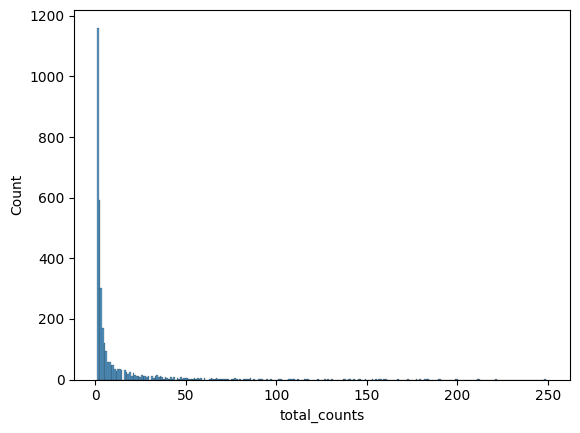

In [45]:
sns.histplot(ec_adata.var.total_counts, binrange=(1, 250))

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_counts', ylabel='Count'>

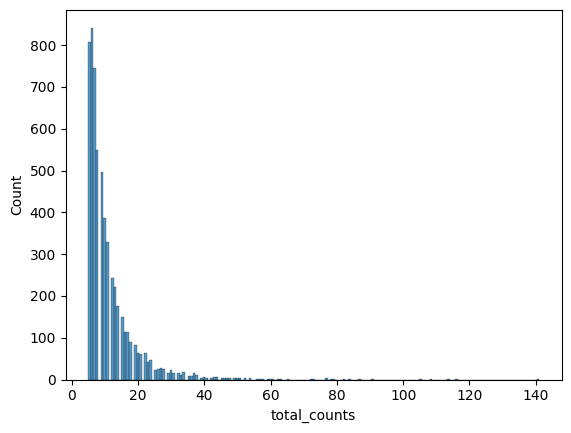

In [46]:
sns.histplot(ec_adata.obs.total_counts)

In [24]:
ec_adata.obs.total_counts

AAGCTGGCCTTCAAAAAAAAAAAAAAAAA    17.0
AAGCTGGCCTTCAAAACAACGACCAGCAC     9.0
AAGCTGGCCTTCAAAAGACTGACGACACC    12.0
AAGCTGGCCTTCAAAATAGCGACTCCTAC     9.0
AAGCTGGCCTTCAAACGTCCCTCATCCTC    12.0
                                 ... 
TTGTTGAACTCCCTTTAGGGACCTCCTAC    15.0
TTGTTGAACTCCCTTTAGGGACGCGTATT     9.0
TTGTTGAACTCCCTTTGGGATGACAGGTG    13.0
TTGTTGAACTCCCTTTGGGATGATCCGTA     7.0
TTGTTGAACTCCCTTTGGGATGATTAAGG    14.0
Name: total_counts, Length: 5964, dtype: float32

In [50]:
ec_adata.obs

,strains,n_genes_by_counts,total_counts,n_genes,n_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAGCTGGCCTTCAAAAAAAAAAAAAAAAA,GSM5456503_Ec_CDS,13,17.0,13,17.0,2.639057,2.890372,100.0,100.0,100.0,100.0
AAGCTGGCCTTCAAAACAACGACCAGCAC,GSM5456503_Ec_CDS,9,9.0,9,9.0,2.302585,2.302585,100.0,100.0,100.0,100.0
AAGCTGGCCTTCAAAAGACTGACGACACC,GSM5456503_Ec_CDS,12,12.0,12,12.0,2.564949,2.564949,100.0,100.0,100.0,100.0
AAGCTGGCCTTCAAAATAGCGACTCCTAC,GSM5456503_Ec_CDS,9,9.0,9,9.0,2.302585,2.302585,100.0,100.0,100.0,100.0
AAGCTGGCCTTCAAACGTCCCTCATCCTC,GSM5456503_Ec_CDS,11,12.0,11,12.0,2.484907,2.564949,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGAACTCCCTTTAGGGACCTCCTAC,GSM5456503_Ec_CDS,15,15.0,15,15.0,2.772589,2.772589,100.0,100.0,100.0,100.0
TTGTTGAACTCCCTTTAGGGACGCGTATT,GSM5456503_Ec_CDS,8,9.0,8,9.0,2.197225,2.302585,100.0,100.0,100.0,100.0
TTGTTGAACTCCCTTTGGGATGACAGGTG,GSM5456503_Ec_CDS,12,13.0,12,13.0,2.564949,2.639057,100.0,100.0,100.0,100.0
TTGTTGAACTCCCTTTGGGATGATCCGTA,GSM5456503_Ec_CDS,7,7.0,7,7.0,2.079442,2.079442,100.0,100.0,100.0,100.0


## 200hvg

In [37]:
sc.pp.highly_variable_genes(ec_adata, n_top_genes=200)
ec_adata_hvg = ec_adata[:, ec_adata.var['highly_variable']].copy()
ec_adata_hvg

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 5964 × 200
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'hvg'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [38]:
ec_adata_hvg.var.total_counts.value_counts()

total_counts
17.0     10
10.0      8
15.0      6
19.0      6
18.0      6
         ..
46.0      1
29.0      1
340.0     1
125.0     1
194.0     1
Name: count, Length: 99, dtype: int64

In [41]:
ec_adata_hvg.var.n_cells

cds-ECs_2640            8
cds-ECs_4414           12
cds-ECs_5338           32
cds-NP_308056.1       132
cds-NP_308058.1        32
                     ... 
cds-NP_313205.1       296
cds-NP_313206.1       142
cds-NP_313220.1         2
cds-NP_313359.1        39
cds-YP_009502673.1      1
Name: n_cells, Length: 200, dtype: int32

In [43]:
tps = get_tps(ec_adata.layers['counts'].A)

ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by eith

In [45]:
np.unique(tps, return_counts=True)

(array(['bin', 'ter', 'tru'], dtype='<U3'),
 array([2985,  315,   79], dtype=int64))

In [53]:
ec_adata.layers['counts'].A.sum(axis=0).shape

(3379,)

In [54]:
tps.shape

(3379,)

In [58]:
ec_adata.layers['counts'].A[:,:1].sum()

2.0

In [78]:
(ec_adata[:,tps == "bin"].X.A != 0).sum(axis=0) == 1

array([False,  True, False, ..., False,  True,  True])

In [85]:
np.where(ec_adata[:,tps == "bin"].X.A[:,0:1] != 0)

(array([ 860, 4967], dtype=int64), array([0, 0], dtype=int64))

In [87]:
tps.shape

(3379,)

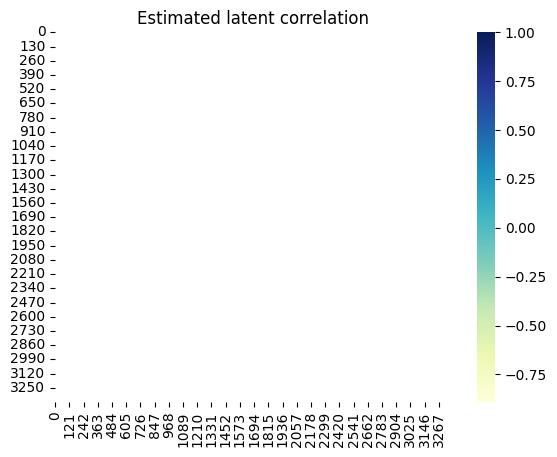

In [88]:
est = latentcor(ec_adata.layers['counts'].A, tps=tps, method='approx', use_nearPD=False, nu=0.001, showplot=True)

In [89]:
est['R']

,0,1,2,3,4,5,6,7,8,9,...,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378
0,1.000000,0.949374,0.949311,0.949374,0.948994,0.949374,0.949374,0.949374,0.949311,0.949247,...,0.949247,0.949374,0.949374,0.949374,0.949374,0.949374,0.949374,0.949374,0.949374,0.949374
1,0.949374,1.000000,0.969655,0.969719,0.969497,0.969687,0.969719,0.969687,0.969655,0.969624,...,0.969624,0.969687,0.969719,0.969687,0.969719,0.969719,0.969687,0.969687,0.969719,0.969719
2,0.949311,0.969655,1.000000,0.928966,0.928490,0.928966,0.928966,0.928966,0.928966,0.928871,...,0.928871,0.928966,0.928966,0.928966,0.928966,0.928966,0.928966,0.928966,0.928966,0.928966
3,0.949374,0.969719,0.928966,1.000000,0.969497,0.969687,0.969719,0.969687,0.969655,0.969624,...,0.969624,0.969687,0.969719,0.969687,0.969719,0.969719,0.969687,0.969687,0.969719,0.969719
4,0.948994,0.969497,0.928490,0.969497,1.000000,0.825974,0.825974,0.825974,0.825974,0.825974,...,0.825974,0.825974,0.825974,0.825974,0.825974,0.825974,0.825974,0.825974,0.825974,0.825974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,0.949374,0.969719,0.928966,0.969719,0.825974,0.949374,0.969719,0.949374,0.928966,0.908495,...,0.908495,0.949374,0.969719,0.949374,0.969719,1.000000,0.969687,0.969687,0.969719,0.969719
3375,0.949374,0.969687,0.928966,0.969687,0.825974,0.949374,0.969687,0.949374,0.928966,0.908495,...,0.908495,0.949374,0.969687,0.949374,0.969687,0.969687,1.000000,0.949374,0.949374,0.949374
3376,0.949374,0.969687,0.928966,0.969687,0.825974,0.949374,0.969687,0.949374,0.928966,0.908495,...,0.908495,0.949374,0.969687,0.949374,0.969687,0.969687,0.949374,1.000000,0.949374,0.949374
3377,0.949374,0.969719,0.928966,0.969719,0.825974,0.949374,0.969719,0.949374,0.928966,0.908495,...,0.908495,0.949374,0.969719,0.949374,0.969719,0.969719,0.949374,0.949374,1.000000,0.969719


In [90]:
s = svd(est['R'], compute_uv=False)
np.any(s<=0)

False

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


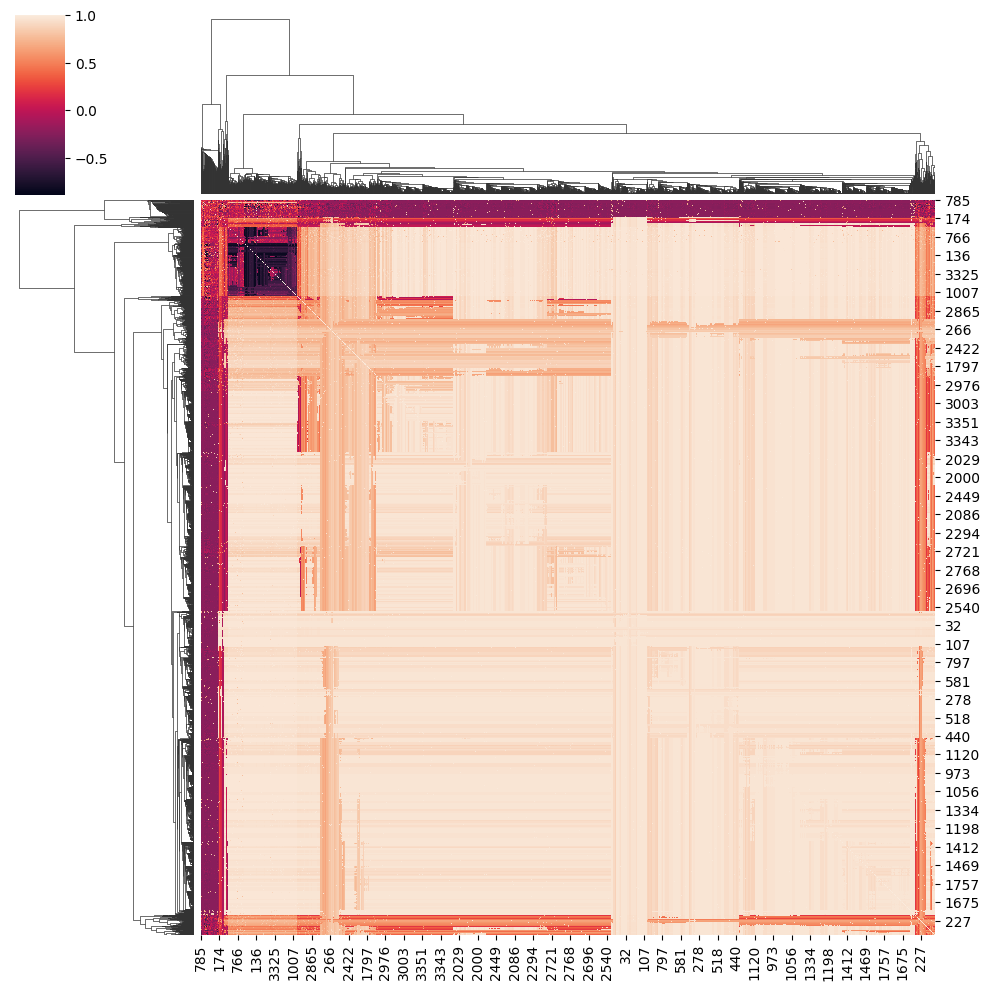

In [91]:
sns.clustermap(est['R'])

In [ ]:
ggl_est = gg_lasso_network_analysis(N=ec_adata.shape[0], estimate=est)
ggl_est.create_problem(S_col='R')
ggl_est.model_selection(lambda1_range=np.logspace(0, -3, 50))

In [ ]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

## 50 hvg

In [3]:
sc.pp.highly_variable_genes(ec_adata, n_top_genes=50)
ec_adata_hvg50 = ec_adata[:, ec_adata.var['highly_variable']].copy()
ec_adata_hvg50

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 5964 × 50
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'hvg'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_counts', ylabel='Count'>

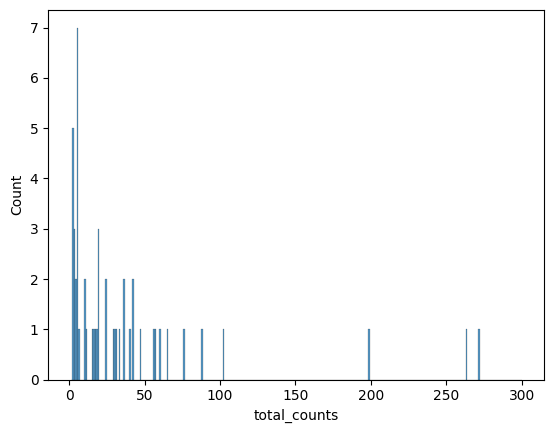

In [57]:
sns.histplot(ec_adata_hvg50.var.total_counts, binrange=(1, 300), bins=300)

Scatter shows that the information in the gen expression matrix contains lots of ones.

<Axes: xlabel='n_cells', ylabel='total_counts'>

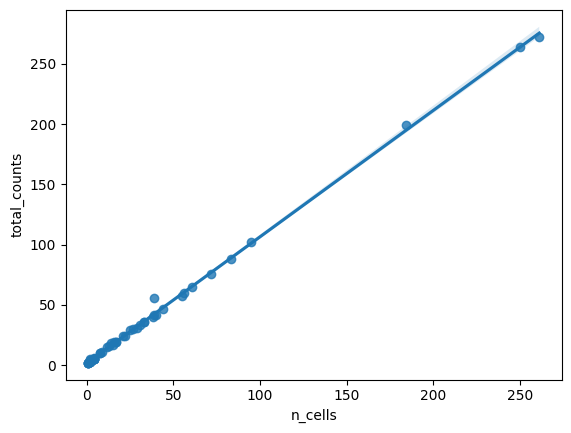

In [59]:
sns.regplot(ec_adata_hvg50.var, x='n_cells', y='total_counts')

In [8]:
ec_adata_hvg50.var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,var_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,log1p_mean_counts,log1p_total_counts
cds-NP_308146.1,GSM5456504_Efm_CDS,match,NP_308146.1,83,0.014755,98.608317,88.0,0.000347,83,True,0.030064,1.703771,4.351936,0.014647,4.488636
cds-NP_308223.1,GSM5456504_Efm_CDS,match,NP_308223.1,27,0.005030,99.547284,30.0,0.000129,27,True,0.011409,1.944163,5.301221,0.005018,3.433987
cds-NP_308473.4,GSM5456504_Efm_CDS,match,NP_308473.4,4,0.000838,99.932931,5.0,0.000024,4,True,0.001934,1.459113,3.385801,0.000838,1.791759
cds-NP_308732.1,GSM5456504_Efm_CDS,match,NP_308732.1,15,0.002850,99.748491,17.0,0.000078,15,True,0.007208,2.240262,6.470494,0.002846,2.890372
cds-NP_308891.1,GSM5456504_Efm_CDS,match,NP_308891.1,3,0.000671,99.949698,4.0,0.000020,3,True,0.001646,1.559108,3.780673,0.000670,1.609438
cds-NP_308930.3,GSM5456504_Efm_CDS,match,NP_308930.3,1,0.000335,99.983233,2.0,0.000014,1,True,0.001071,1.854587,4.947493,0.000335,1.098612
cds-NP_309059.1,GSM5456504_Efm_CDS,match,NP_309059.1,40,0.007042,99.329309,42.0,0.000163,40,True,0.014333,1.714625,4.394796,0.007018,3.761200
cds-NP_309498.1,GSM5456504_Efm_CDS,match,NP_309498.1,61,0.010899,98.977197,65.0,0.000269,61,True,0.026697,2.950286,9.274318,0.010840,4.189655
cds-NP_309521.1,GSM5456504_Efm_CDS,match,NP_309521.1,25,0.004863,99.580818,29.0,0.000133,25,True,0.011613,1.990944,5.485959,0.004851,3.401197
cds-NP_310334.1,GSM5456504_Efm_CDS,match,NP_310334.1,12,0.002515,99.798793,15.0,0.000092,12,True,0.012083,3.690559,12.197594,0.002512,2.772589


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


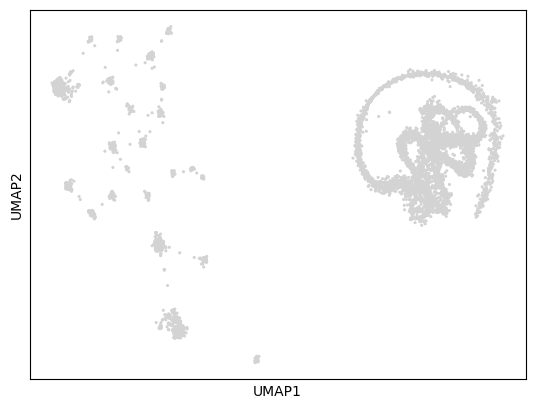

In [5]:
sc.pp.neighbors(ec_adata_hvg50, use_rep='X')
sc.tl.umap(ec_adata_hvg50)
sc.pl.umap(ec_adata_hvg50)

In [6]:
sc.pp.calculate_qc_metrics(ec_adata_hvg50, inplace=True, percent_top=(5, 10, 25))

In [7]:
ec_adata_hvg50.obs

,strains,n_genes_by_counts,total_counts,n_genes,n_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_5_genes,pct_counts_in_top_10_genes,pct_counts_in_top_25_genes
AAGCTGGCCTTCAAAAAAAAAAAAAAAAA,GSM5456503_Ec_CDS,0,0.0,13,17.0,0.000000,0.000000,NaN,NaN,NaN
AAGCTGGCCTTCAAAACAACGACCAGCAC,GSM5456503_Ec_CDS,0,0.0,9,9.0,0.000000,0.000000,NaN,NaN,NaN
AAGCTGGCCTTCAAAAGACTGACGACACC,GSM5456503_Ec_CDS,0,0.0,12,12.0,0.000000,0.000000,NaN,NaN,NaN
AAGCTGGCCTTCAAAATAGCGACTCCTAC,GSM5456503_Ec_CDS,0,0.0,9,9.0,0.000000,0.000000,NaN,NaN,NaN
AAGCTGGCCTTCAAACGTCCCTCATCCTC,GSM5456503_Ec_CDS,0,0.0,11,12.0,0.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
TTGTTGAACTCCCTTTAGGGACCTCCTAC,GSM5456503_Ec_CDS,0,0.0,15,15.0,0.000000,0.000000,NaN,NaN,NaN
TTGTTGAACTCCCTTTAGGGACGCGTATT,GSM5456503_Ec_CDS,0,0.0,8,9.0,0.000000,0.000000,NaN,NaN,NaN
TTGTTGAACTCCCTTTGGGATGACAGGTG,GSM5456503_Ec_CDS,1,1.0,12,13.0,0.693147,0.693147,100.0,100.0,100.0
TTGTTGAACTCCCTTTGGGATGATCCGTA,GSM5456503_Ec_CDS,0,0.0,7,7.0,0.000000,0.000000,NaN,NaN,NaN


Due to only selecting top50 HVGs lots of cells only contain zeros

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

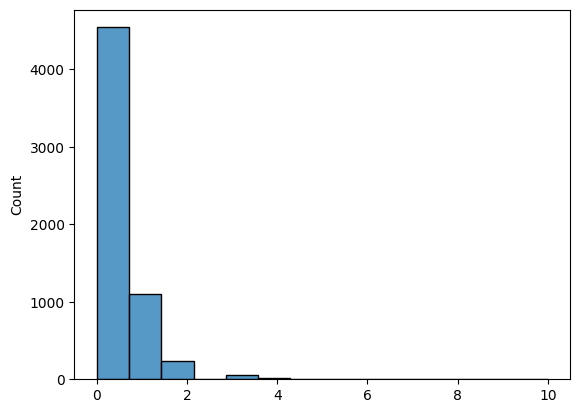

In [9]:
sns.histplot(ec_adata_hvg50.X.A.sum(axis=1))

In [10]:
np.unique(ec_adata_hvg50.X.A.sum(axis=1), return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10.], dtype=float32),
 array([4542, 1098,  239,   58,   17,    7,    2,    1], dtype=int64))

1) remove genes that are only expressed in one cell
2) Remove cells that do not express any of the remaining genes

In [11]:
print(ec_adata_hvg50.shape)
sc.pp.filter_genes(ec_adata_hvg50, min_cells=2)
print(ec_adata_hvg50.shape)

(5964, 50)
(5964, 45)


In [13]:
print(ec_adata_hvg50.shape)
sc.pp.filter_cells(ec_adata_hvg50, min_genes=1)
print(ec_adata_hvg50.shape)

(1419, 45)
(1419, 45)


In [14]:
np.unique(ec_adata_hvg50.X.A.sum(axis=1), return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6., 10.], dtype=float32),
 array([1099,  236,   58,   17,    6,    2,    1], dtype=int64))

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


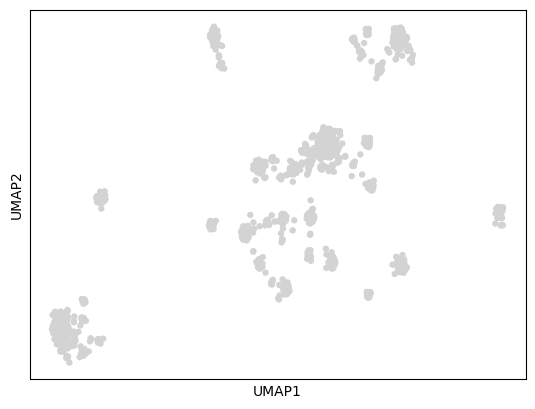

In [15]:
sc.pp.neighbors(ec_adata_hvg50, use_rep='X')
sc.tl.umap(ec_adata_hvg50)
sc.pl.umap(ec_adata_hvg50)

Checking what types latent core estimates --> No binaries! Lots of ternary but from biology we should know that they are in fact truncated (havy zero inflated)

In [18]:
tps = get_tps(ec_adata_hvg50.layers['counts'].A)

ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by eith

In [19]:
np.unique(tps, return_counts=True)

(array(['ter', 'tru'], dtype='<U3'), array([31, 14], dtype=int64))

Estimating with all considered truncated

In [21]:
tps_hvg = ['tru' for i in range(ec_adata_hvg50.shape[1])]

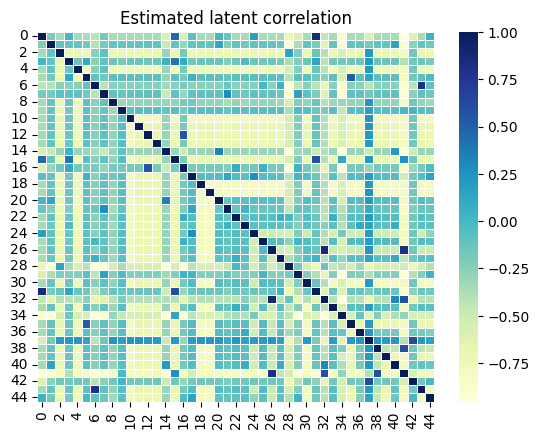

In [69]:
est = latentcor(ec_adata_hvg50.layers['counts'].A, tps=tps, method='approx', use_nearPD=False, nu=0.001, showplot=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


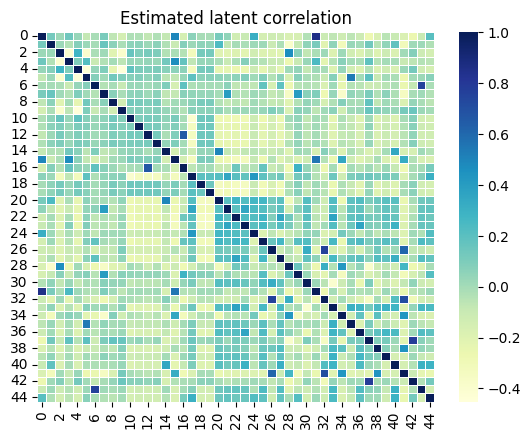

In [64]:
est = latentcor(ec_adata_hvg50.layers['counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [70]:
evals, evecs = np.linalg.eig(est['R'])
assert np.all(evals>0)

AssertionError: 

Trying to bring R back to pos def

In [46]:
from numpy import linalg as la

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [51]:
R = nearestPD(est['R'].to_numpy())

In [53]:
est['R'] = pd.DataFrame(R)

In [108]:
'''
s = svd(est['R'], compute_uv=False)
assert np.all(s>0)
'''

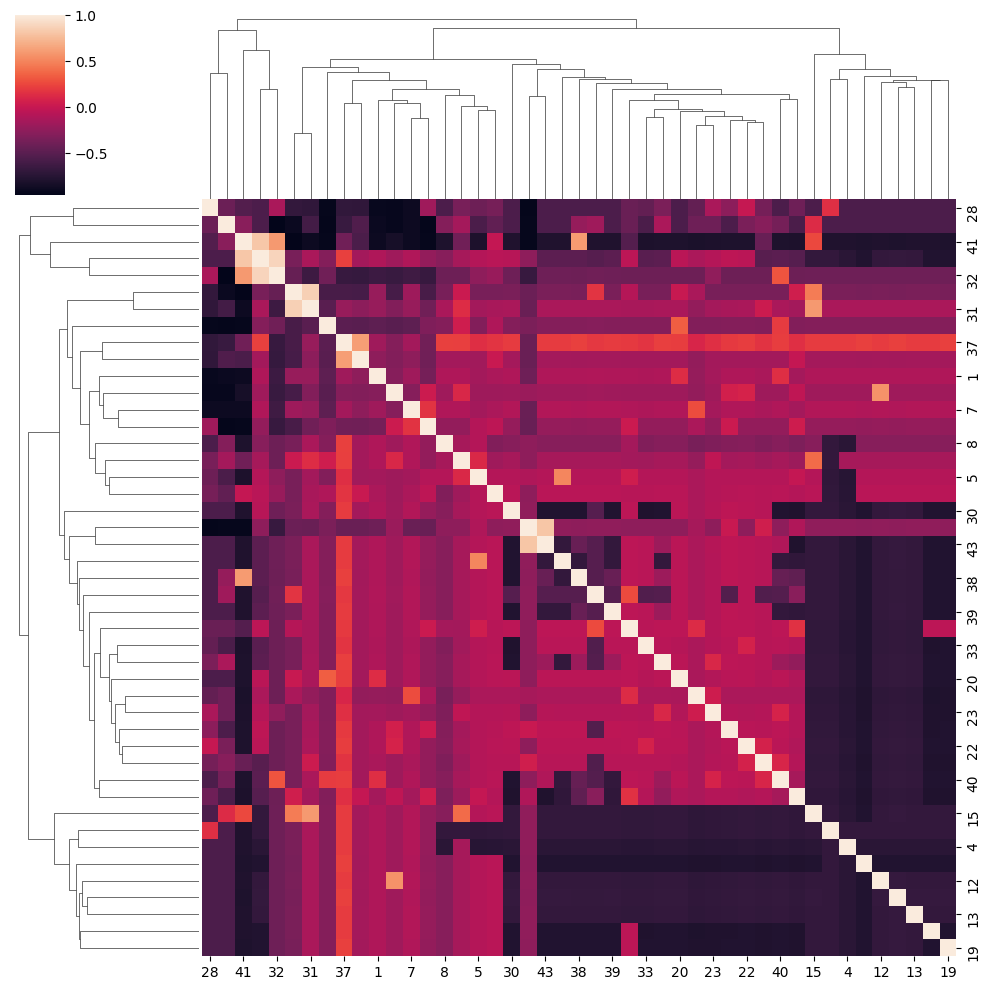

In [71]:
sns.clustermap(est['R'])

In [76]:
ggl_est = gg_lasso_network_analysis(N=ec_adata_hvg50.shape[0], estimate=est)
ggl_est.create_problem(S_col='R')
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 500))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminated after 109 iterations with status: optimal.
ADMM terminated after 329 iterations 

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 1.52587890625e-05.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 1.52587890625e-05.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 3.0517578125e-05.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 3.0517578125e-05.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 6.103515625e-05.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 6.103515625e-05.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal opti

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 64.0.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 64.0.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 128.0.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 128.0.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal opti

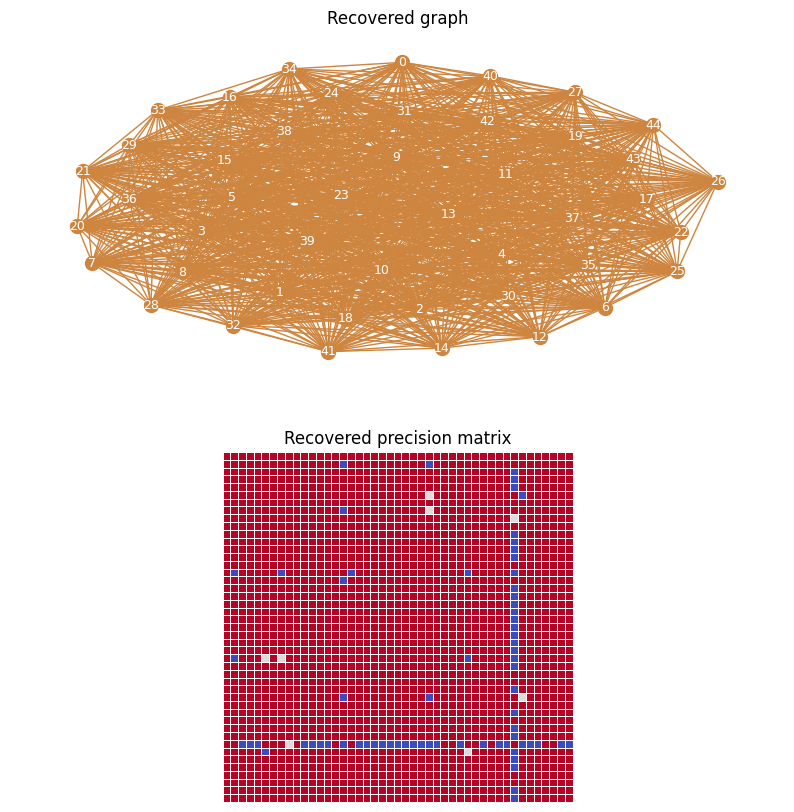

In [77]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))